Deep Learning method to differentiate dogs and cats in pictures
深度学习区分猫狗图片程序
###  https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
##### jiuzhang lecture

In [1]:
import cv2 # please install cv module: pip3 install opencv-python, or python -m pip install opencv-python
import numpy as np 
import os 
from random import shuffle # for randomization 
from tqdm import tqdm # for progress tracking
import matplotlib.pyplot as plt 

In [24]:
train_dir = 'C:/Users/Administrator/Downloads/Compressed/train/'
test_dir = 'C:/Users/Administrator/Downloads/Compressed/test/test/'
img_size = 50
lr = 1e-3

将label变成每个类别的概率（类似于哑变量）
Convert label for each image to probability, similar to dummy variable

In [3]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

处理训练数据，大约需要30秒
Train the traning data, approx. 30sec

In [4]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(train_dir)):
        if (not img.endswith('.jpg')):
            continue
        label = label_img(img)
        path = os.path.join(train_dir, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # 读入灰度图 read grayscale
        img = cv2.resize(img, (img_size, img_size) )  # 将图片变成统一大小 resize an image to preset size
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    return training_data
        

In [5]:
train_data = create_train_data()

100%|███████████████████████████████████| 25000/25000 [01:21<00:00, 307.90it/s]


处理测试数据，注意没有label信息
Process test data, note there's no label

In [27]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(test_dir)):
        if (not img.endswith('.jpg')):
            continue
        path = os.path.join(test_dir,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    return testing_data

导入基于Tensorflow的高级深度学习库tflearn
Need to import Tensorflow model, tflearn

In [7]:
import tflearn # 需要安装tensorflow，然后安装tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d  # 2维CNN以及最大采样
from tflearn.layers.core import input_data, dropout, fully_connected # 输入层，dropout，全连接层
from tflearn.layers.estimator import regression # cross entropy层

C:\Users\Administrator\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)


注意：如果多次运行不同的网络结构图，每次需要先清空图
Warning: before every run, need to empty first using reset_default_graph

In [8]:
import tensorflow as tf
tf.reset_default_graph()

In [9]:
convnet = input_data(shape = [None, img_size, img_size, 1], name = 'input')

3个CNN及2个max pooling层

-- conv_2d(convnet, 32, 5, activation='relu')表示建立32个filter，每一个大小都是5x5xchannel。因为默认使用"SAME" padding,加了0使得每个点都可以对应filter左上角

-- max_pool_2d(convnet, 5)表示对于输出的每个5x5的区域求最大值

In [10]:
convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

# 这里这样设置，是借鉴前人，确实有效果

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


两个全连接层与预测层

In [11]:
convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8) #存活概率

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate = lr, loss='categorical_crossentropy', name='targets')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [12]:
model = tflearn.DNN(convnet, tensorboard_dir='log')

In [13]:
train = train_data[:-500]

In [14]:
test = train_data[-500:] # for validation

In [15]:
X = np.array([i[0] for i in train], dtype=np.float64).reshape(-1, img_size, img_size, 1)
y = np.array([i[1] for i in train], dtype=np.float64)
Xtest = np.array([i[0] for i in test], dtype=np.float64).reshape(-1, img_size, img_size, 1)
ytest = np.array([i[1] for i in test], dtype=np.float64)
# test is validation here

在训练集上训练，无GPU大约需要2-3分钟

In [16]:
model.fit({'input': X}, {'targets': y}, n_epoch=3, validation_set=({'input': Xtest}, {'targets': ytest}), snapshot_step=500, show_metric=True, run_id='model' )

Training Step: 1148  | total loss: 0.45370 | time: 161.738s
| Adam | epoch: 003 | loss: 0.45370 - acc: 0.7916 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.47361 | time: 163.151s
| Adam | epoch: 003 | loss: 0.47361 - acc: 0.7812 | val_loss: 0.49254 - val_acc: 0.7560 -- iter: 24500/24500
--


读入测试数据，大约需要30秒

In [31]:
test_data = process_test_data()

100%|███████████████████████████████████| 12500/12500 [01:57<00:00, 106.56it/s]


In [18]:
# validation results
pred = np.array([0 if x[0] > x[1] else 1 for x in model.predict(Xtest)])
answer = np.array([0 if x[0] > x[1] else 1 for x in ytest])
sum(pred == answer) / len(pred) * 100.0

75.6

In [19]:
answer

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,

输出测试数据上一些例子的预测
Now we can test some cases from test dataset

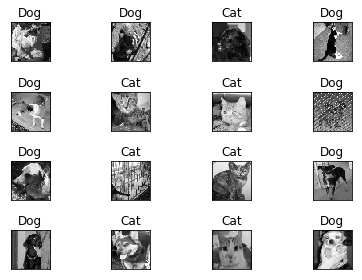

In [34]:
fig = plt.figure()
for num, data in enumerate(test_data[:16]):
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(4, 4, num+1)
    orig = img_data
    data = img_data.reshape(img_size, img_size, 1)
    model_out = model.predict([data])[0]
    if np.argmax(model_out) == 1: 
        label = 'Dog'
    else: 
        label = 'Cat'
    
    y.imshow(orig, cmap='gray')
    plt.title(label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
    #print(num, data, label)
    
plt.tight_layout()
plt.show()

In [ ]:
#pyenv install -list

In [ ]:
#logistic regression

lr_Xtrain = [np.ravelx[0] for x in train]
lr_Xtrain = np.asmatrix(lr_Xtrain)
lr_Ytrain = np.ravel(x[1][0] for x in train)
lr_Xtrain = lr_Xtrain / 255.0